In [ ]:
import cv2
import torch
import torch.nn.functional as F
from torchvision import transforms
from PIL import Image
import numpy as np

# ================================================
# 📥 How to Download u2net.py and u2netp.pth
# ================================================
# To use the U2NETP model, you need two files:
#
# 1️⃣ u2net.py
#   - Defines the U2NET/U2NETP model class.
#   - Download it from the official repo:
#     https://github.com/xuebinqin/U-2-Net
#   - Get it from the 'model' folder or download the whole repo.
#
# 2️⃣ u2netp.pth
#   - Pre-trained weights for the lightweight U2NETP model.
#   - Download from the Releases page:
#     https://github.com/xuebinqin/U-2-Net/releases
#   - Direct link to weights:
#     https://github.com/xuebinqin/U-2-Net/releases/download/v1.0/u2netp.pth
#
# How to Use:
#   - Place u2net.py in your project directory or in your Python path.
#   - Place u2netp.pth in the same folder as this script,
#     or adjust the path in torch.load() below.

from u2net import U2NETP

model = U2NETP(3, 1)
model.load_state_dict(torch.load(
    'u2netp.pth', map_location=torch.device('cpu')))
model.eval()

transform = transforms.Compose([
    transforms.Resize((320, 320)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])


def get_background_mask(frame):
    image = Image.fromarray(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
    tensor = transform(image).unsqueeze(0)

    with torch.no_grad():
        d1, *_ = model(tensor)
        pred = d1[:, 0, :, :]
        pred = F.interpolate(pred.unsqueeze(
            0), size=image.size[::-1], mode='bilinear').squeeze().cpu().numpy()
        mask = (pred - pred.min()) / (pred.max() - pred.min() + 1e-8)

    mask = (mask * 255).astype(np.uint8)
    background_mask = cv2.bitwise_not(mask)
    return background_mask


def get_edges_canny(image, low_threshold=50, high_threshold=150):
    if len(image.shape) == 3:
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    else:
        gray = image

    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    edges = cv2.Canny(blurred, low_threshold, high_threshold)

    return edges

In [ ]:
import cv2
import numpy as np


class CameraMovedDetector:
    def __init__(self, threshold):
        self.threshold = threshold

    def process_frame(self, frame1, frame2):
        mask1 = get_background_mask(frame1)
        mask2 = get_background_mask(frame2)
        intersect_mask = cv2.bitwise_and(mask1, mask2)
        bg1_area = np.sum(mask1 == 255)
        bg2_area = np.sum(mask2 == 255)
        intersection_area = np.sum(intersect_mask == 255)
        ratio = intersection_area / max(bg1_area, bg2_area, 1)
        camera_moved = ratio < self.threshold
        return camera_moved

In [ ]:
import cv2
import numpy as np


class CameraCoveredDetector:
    def __init__(self, threshold):
        self.cover_th = threshold

    def weighted_contour_length(self, contours, mask):
        total_weighted_length = 0.0
        for cnt in contours:
            contour_mask = np.zeros(mask.shape, dtype=np.uint8)
            cv2.drawContours(contour_mask, [cnt], -1, color=255, thickness=1)
            ys, xs = np.where(contour_mask == 255)
            weights = mask[ys, xs].astype(np.float32) / 255.0
            total_weighted_length += np.sum(weights)
        return total_weighted_length

    def process_frame(self, frame1, frame2):
        mask1 = get_background_mask(frame1)
        mask2 = get_background_mask(frame2)
        edges1 = get_edges_canny(frame1)
        edges2 = get_edges_canny(frame2)
        contours1, _ = cv2.findContours(
            edges1, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        contours2, _ = cv2.findContours(
            edges2, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        total_length1 = self.weighted_contour_length(contours1, mask1)
        total_length2 = self.weighted_contour_length(contours2, mask2)
        if max(total_length1, total_length2) == 0:  # expected defocus -> no contours
            return False
        diff_ratio = abs(total_length1 - total_length2) / \
            max(total_length1, total_length2)
        return diff_ratio > self.cover_th

In [ ]:
import cv2


class CameraDefocussedDetector:
    def __init__(self, threshold):
        self.threshold = threshold

    def process_frame(self, frame1, frame2):
        gray1 = cv2.cvtColor(frame1, cv2.COLOR_BGR2GRAY)
        gray2 = cv2.cvtColor(frame2, cv2.COLOR_BGR2GRAY)
        laplacian_var1 = cv2.Laplacian(gray1, cv2.CV_64F).var()
        laplacian_var2 = cv2.Laplacian(gray2, cv2.CV_64F).var()
        defocuss_ratio = laplacian_var2 / laplacian_var1
        return defocuss_ratio < self.threshold

In [ ]:
class CameraSabotageDetector:
    def __init__(self, defocussed_th=0.85, covered_th=0.80, moved_th=0.875):
        self.covered_detector = CameraCoveredDetector(covered_th)
        self.moved_detector = CameraMovedDetector(moved_th)
        self.defocussed_detector = CameraDefocussedDetector(defocussed_th)

    def process(self, frame1, frame2):
        covered = self.covered_detector.process_frame(frame1, frame2)
        moved = self.moved_detector.process_frame(frame1, frame2)
        defocussed = self.defocussed_detector.process_frame(frame1, frame2)

        return {
            "covered": covered,
            "moved": moved,
            "defocussed": defocussed,
        }

In [ ]:
import os
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

CLASS_NAMES = ['normal', 'covered', 'defocussed', 'moved']
CLASS_TO_IDX = {
    'normal': 0,
    'covered': 1,
    'defocussed': 2,
    'moved': 3
}
IDX_TO_CLASS = {
    0: 'normal',
    1: 'covered',
    2: 'defocussed',
    3: 'moved'
}


class SabotageTester:
    def __init__(self, base_path, camera_name, detector,
                 step=1, skip=100):
        self.base_path = base_path
        self.camera_name = camera_name
        self.detector = detector
        self.step = step
        self.skip = skip
        self.max_samples_per_class = [15, 15, 15, 15]
        self.max_samples = sum(self.max_samples_per_class)

    def _load_annotations(self, annotation_path):
        if not os.path.exists(annotation_path):
            return None
        df = pd.read_csv(annotation_path, header=None)
        return df.iloc[:, 1].values  # метки в 2-м столбце

    def run(self):
        processed_per_class = [0, 0, 0, 0]
        test_path = os.path.join(
            self.base_path, self.camera_name, "Testing video")
        examples = []

        for root, _, files in os.walk(test_path):
            for file in files:
                if not file.endswith(".avi"):
                    continue

                video_path = os.path.join(root, file)
                annotation_path = os.path.join(root, "annotations.csv")
                labels = self._load_annotations(annotation_path)

                cap = cv2.VideoCapture(video_path)

                total_frames = len(labels)
                frame_idx = 0

                while frame_idx + self.step < total_frames and sum(processed_per_class) < self.max_samples:
                    # no need in pairs sabotage/sabotage and sabotage/normal
                    if labels[frame_idx] != 0:
                        frame_idx += self.skip
                        continue

                    next_frame_idx = frame_idx + self.step
                    true_label = labels[next_frame_idx]

                    if processed_per_class[true_label] < self.max_samples_per_class[true_label]:
                        cap.set(cv2.CAP_PROP_POS_FRAMES, frame_idx)
                        ret1, frame1 = cap.read()

                        cap.set(cv2.CAP_PROP_POS_FRAMES, frame_idx + self.step)
                        ret2, frame2 = cap.read()

                        if not (ret1 and ret2):
                            frame_idx += self.step
                            continue

                        else:
                            examples.append((frame1, frame2, true_label))

                        processed_per_class[true_label] += 1
                        frame_idx += self.skip

                    else:
                        skipped = False
                        while frame_idx + self.skip < total_frames and labels[frame_idx + self.skip] == true_label:
                            skipped = True
                            frame_idx += self.skip
                        if not skipped:
                            frame_idx += self.step

                cap.release()

        np.random.shuffle(examples)

        for frame1, frame2, true_label in examples:
            result = self.detector.process(frame1, frame2)
            pred_label = 0
            for class_name in ["defocussed", "covered", "moved"]:
                if result[class_name]:
                    pred_label = CLASS_TO_IDX[class_name]
                    break

            fig, axs = plt.subplots(1, 2, figsize=(8, 6))

            axs[0].imshow(cv2.cvtColor(frame1, cv2.COLOR_BGR2RGB))
            axs[0].set_title('First Frame')
            axs[0].axis('off')

            axs[1].imshow(cv2.cvtColor(frame2, cv2.COLOR_BGR2RGB))
            axs[1].set_title('Second Frame')
            axs[1].axis('off')

            plt.tight_layout()
            plt.show()

            print(f"[TRUE] {IDX_TO_CLASS[true_label]}")
            print(f"[PREDICTED] {IDX_TO_CLASS[pred_label]}")
            print("~"*50)

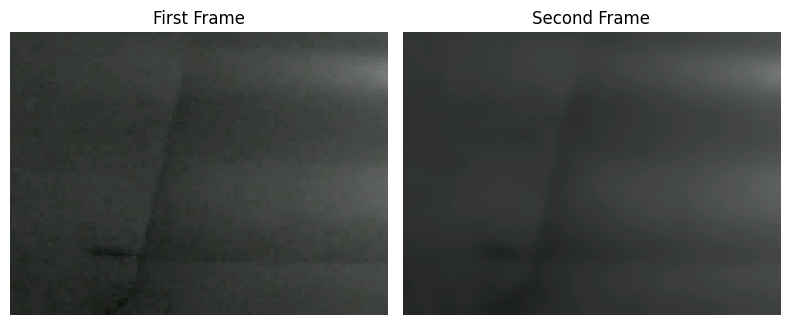

[TRUE] defocussed
[PREDICTED] defocussed
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


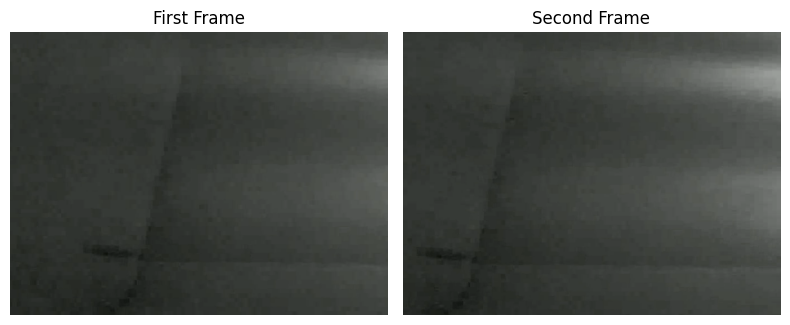

[TRUE] moved
[PREDICTED] moved
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


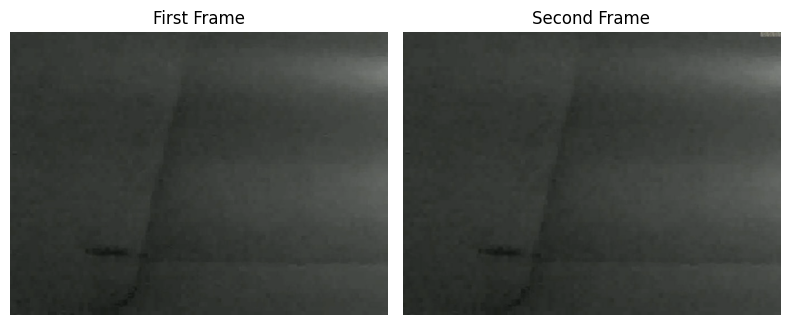

[TRUE] covered
[PREDICTED] covered
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


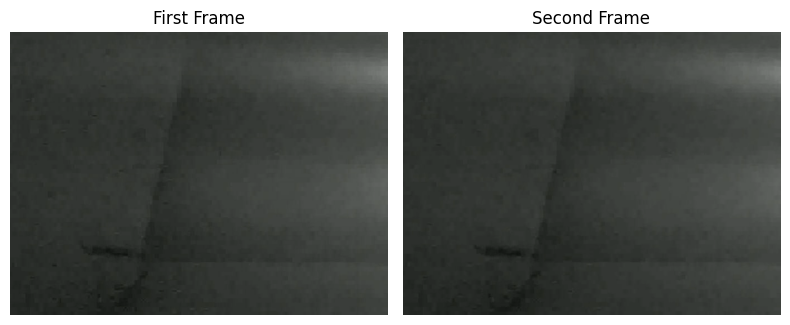

[TRUE] defocussed
[PREDICTED] defocussed
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


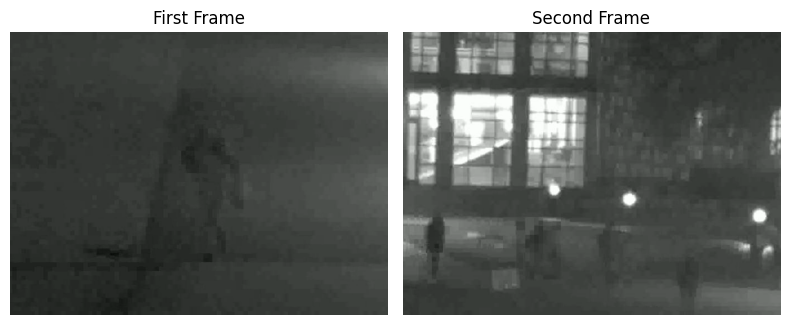

[TRUE] moved
[PREDICTED] covered
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


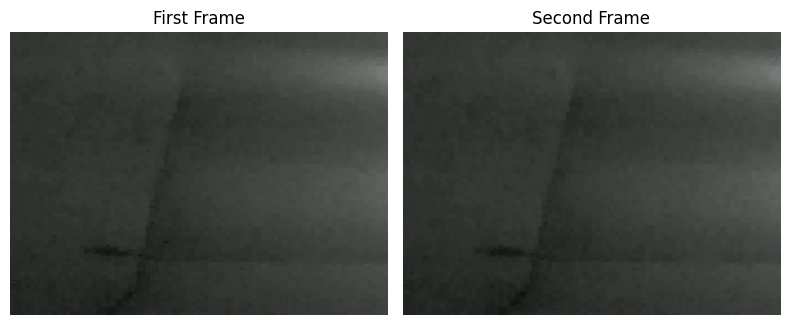

[TRUE] defocussed
[PREDICTED] defocussed
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


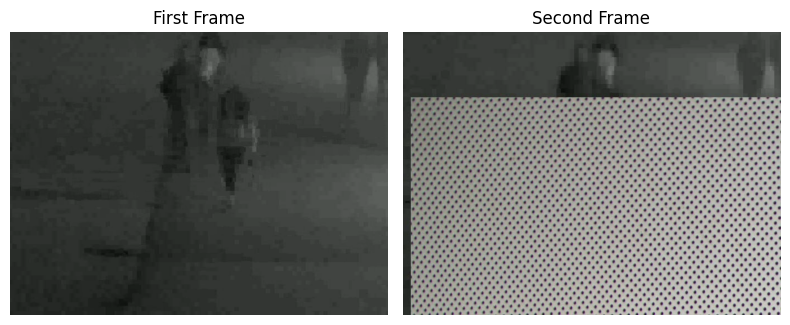

[TRUE] covered
[PREDICTED] covered
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


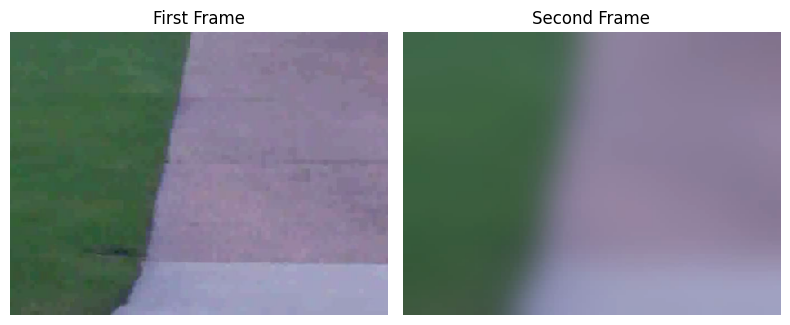

[TRUE] defocussed
[PREDICTED] defocussed
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


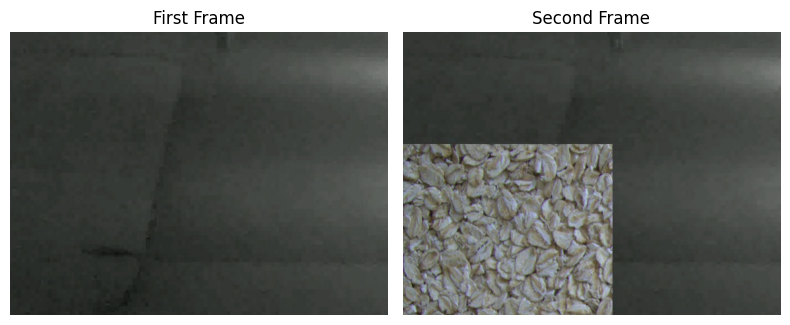

[TRUE] covered
[PREDICTED] covered
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


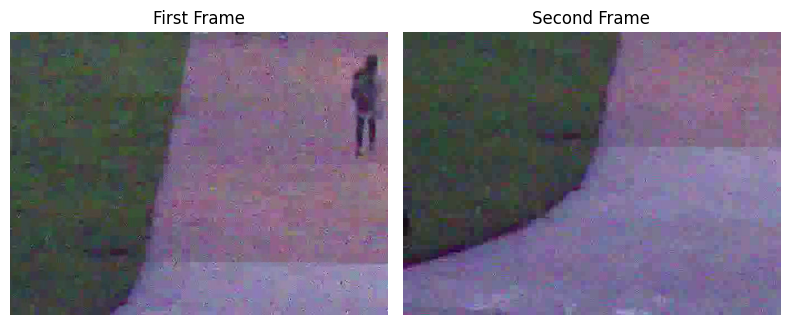

[TRUE] moved
[PREDICTED] defocussed
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


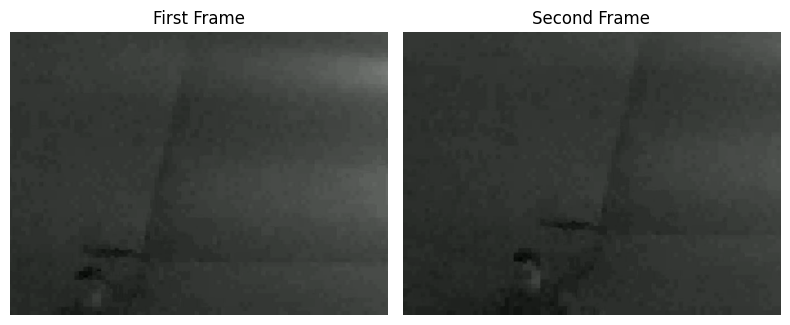

[TRUE] moved
[PREDICTED] moved
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


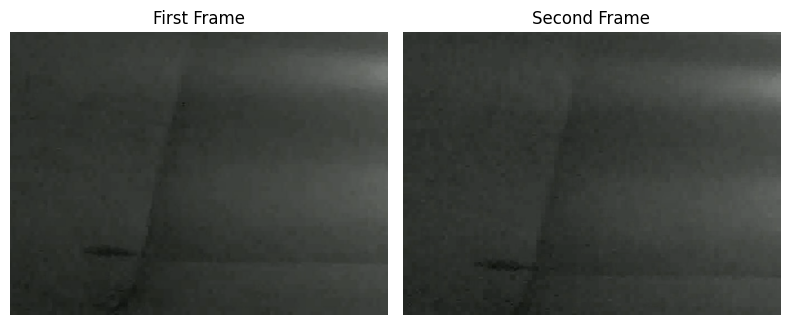

[TRUE] moved
[PREDICTED] moved
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


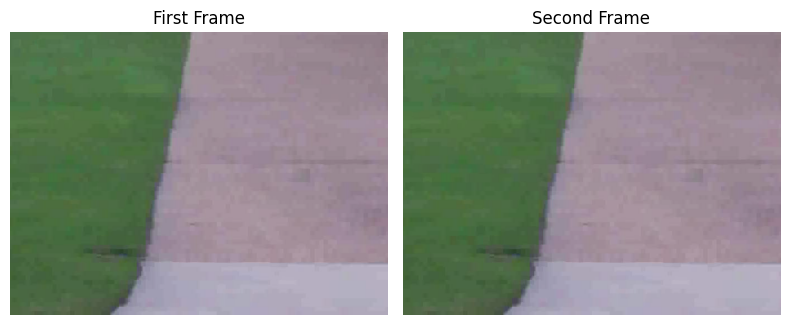

[TRUE] normal
[PREDICTED] normal
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


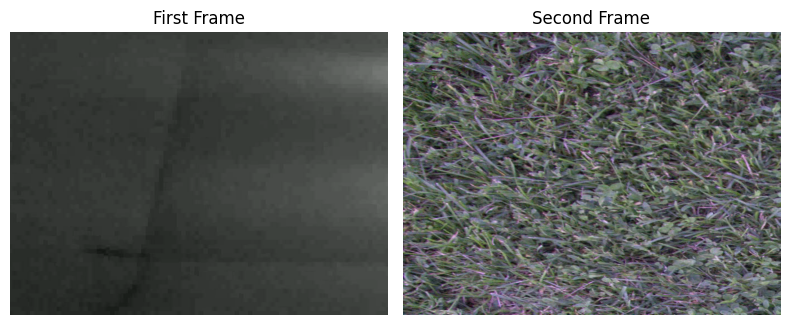

[TRUE] covered
[PREDICTED] covered
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


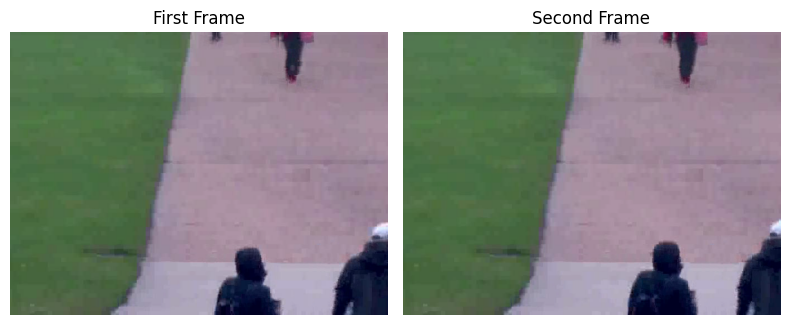

[TRUE] normal
[PREDICTED] normal
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


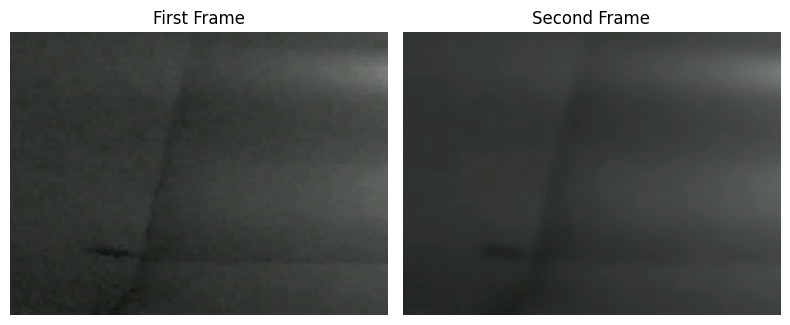

[TRUE] defocussed
[PREDICTED] defocussed
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


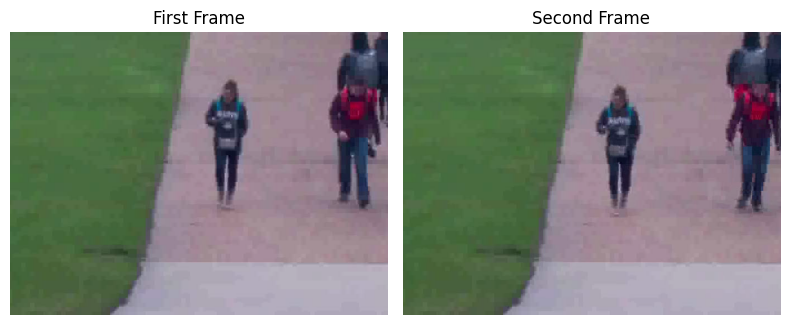

[TRUE] normal
[PREDICTED] normal
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


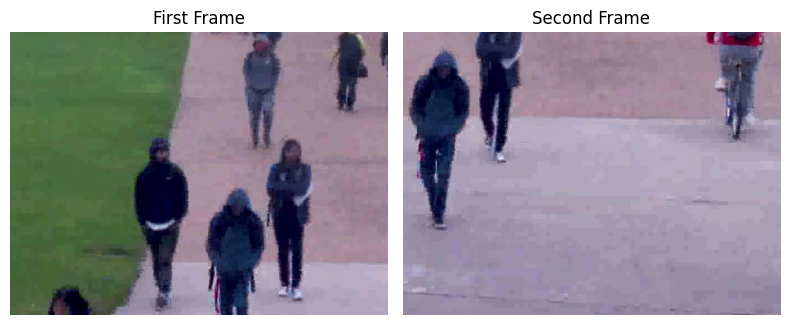

[TRUE] moved
[PREDICTED] moved
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


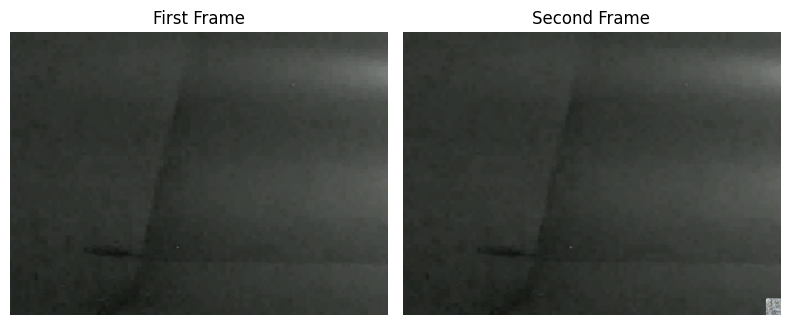

[TRUE] covered
[PREDICTED] covered
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


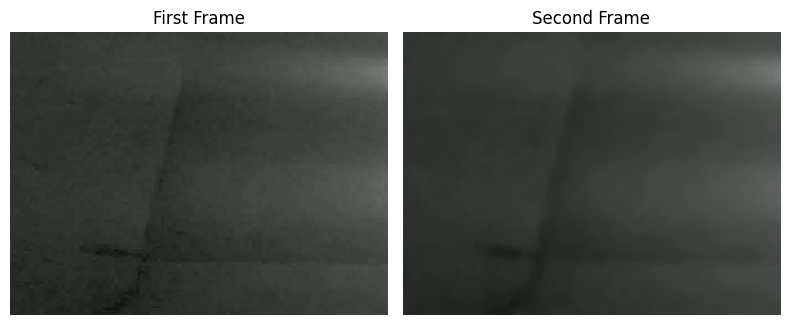

[TRUE] defocussed
[PREDICTED] defocussed
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


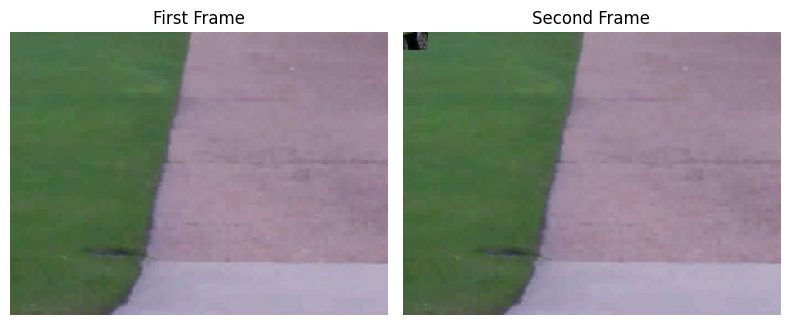

[TRUE] covered
[PREDICTED] normal
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


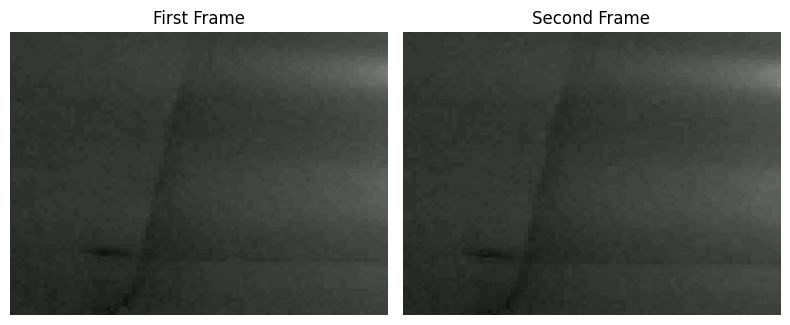

[TRUE] moved
[PREDICTED] moved
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


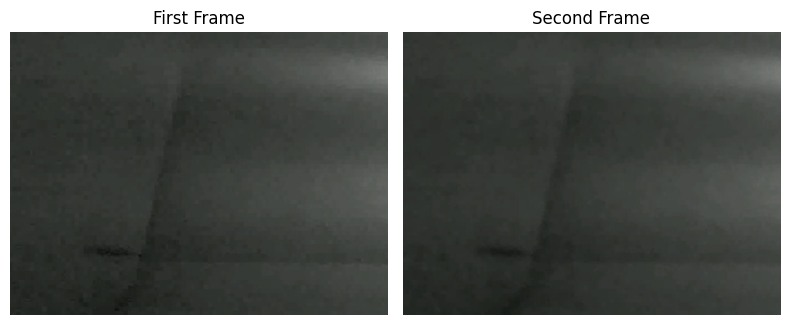

[TRUE] defocussed
[PREDICTED] defocussed
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


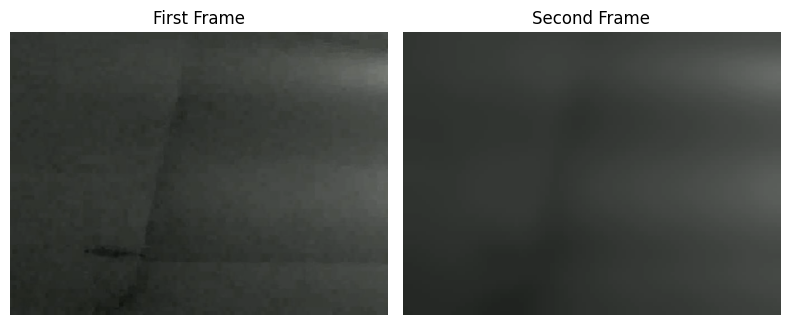

[TRUE] defocussed
[PREDICTED] defocussed
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


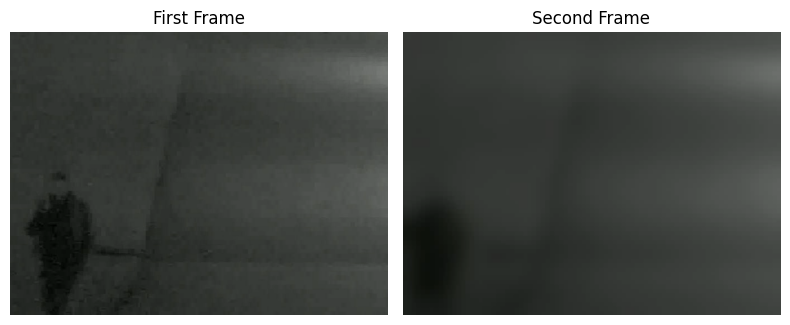

[TRUE] defocussed
[PREDICTED] defocussed
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


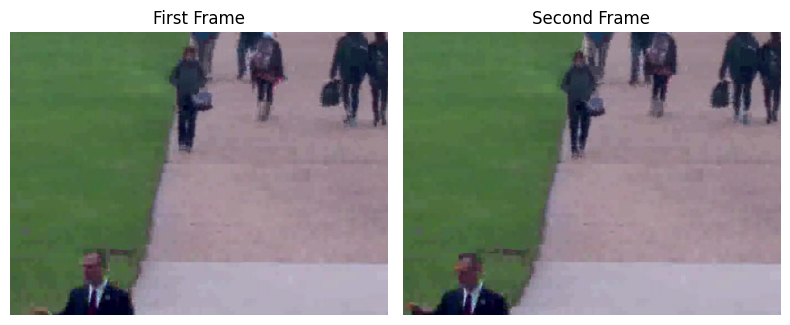

[TRUE] normal
[PREDICTED] normal
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


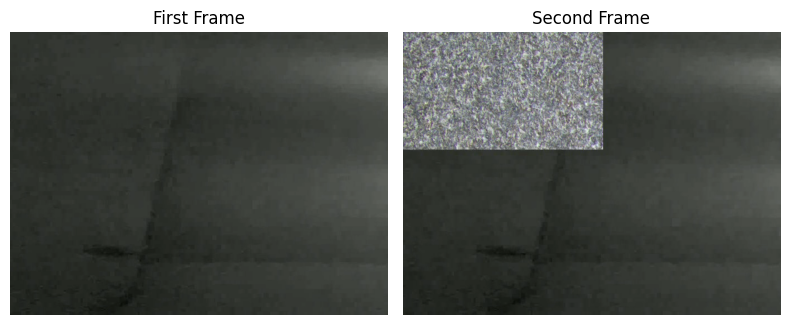

[TRUE] covered
[PREDICTED] covered
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


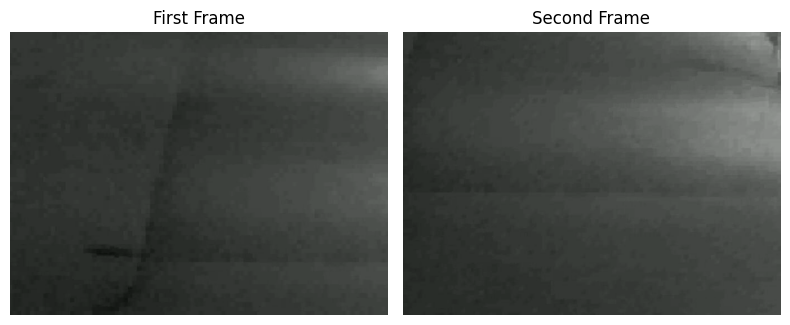

[TRUE] moved
[PREDICTED] moved
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


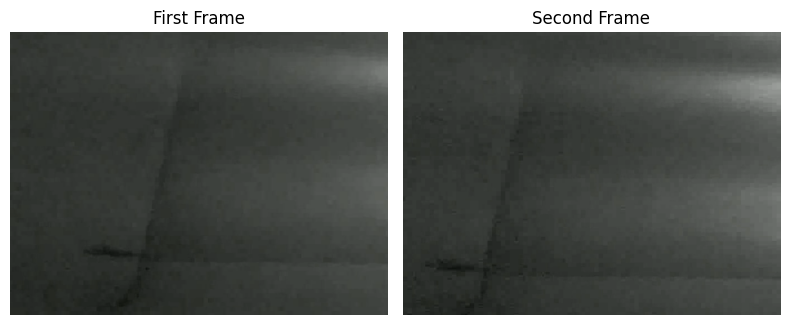

[TRUE] moved
[PREDICTED] moved
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


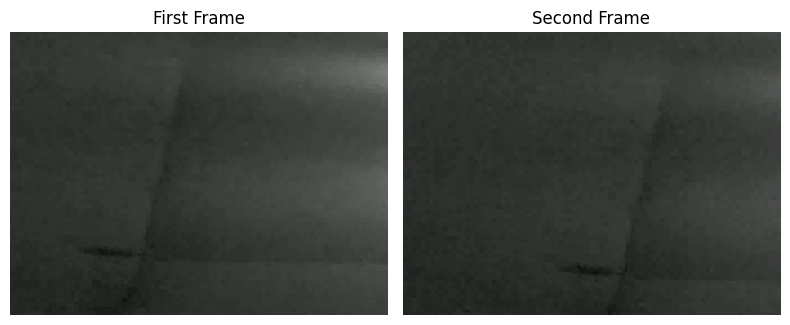

[TRUE] moved
[PREDICTED] moved
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


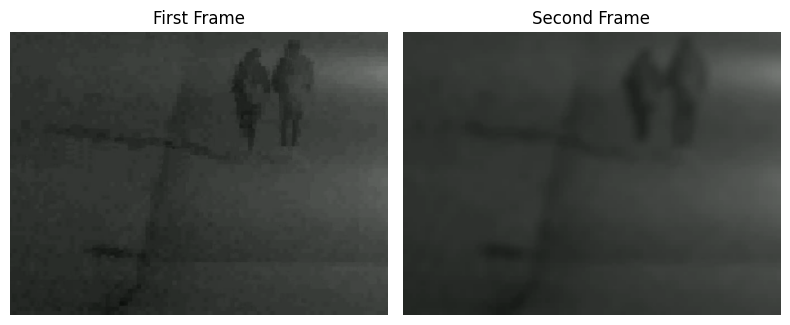

[TRUE] defocussed
[PREDICTED] defocussed
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


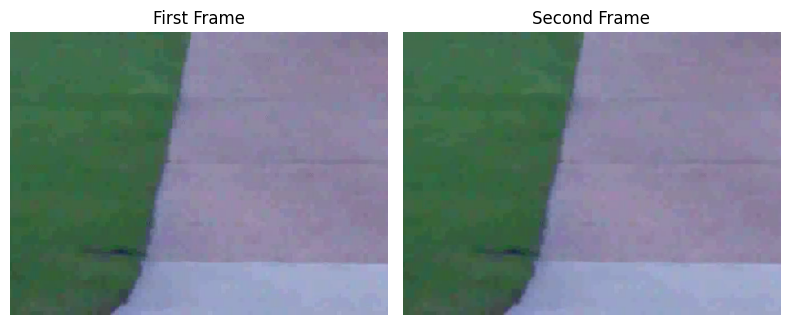

[TRUE] defocussed
[PREDICTED] defocussed
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


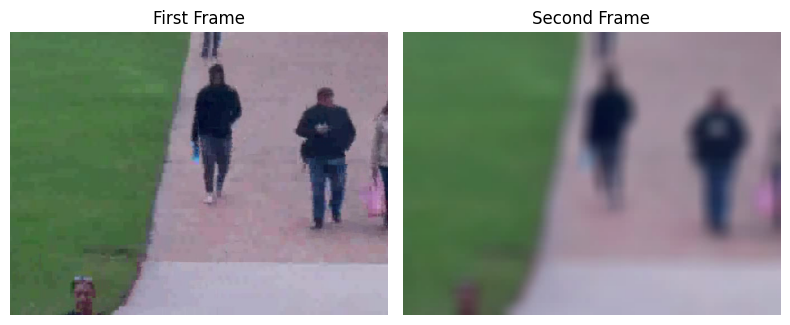

[TRUE] defocussed
[PREDICTED] defocussed
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


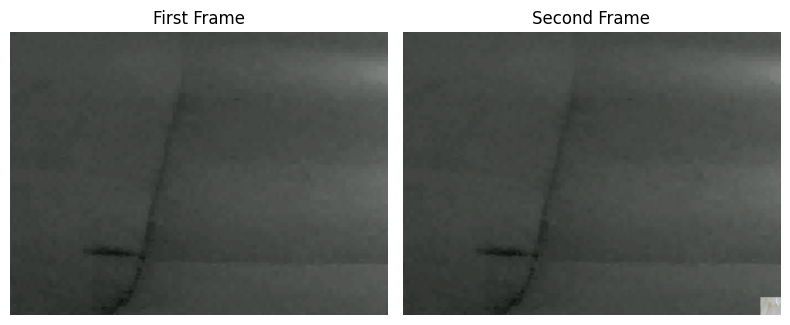

[TRUE] covered
[PREDICTED] covered
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


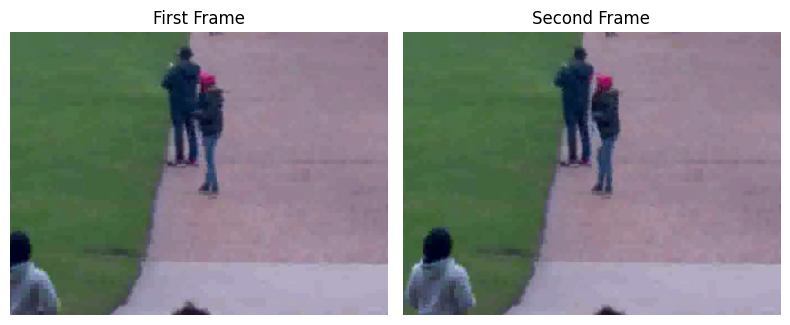

[TRUE] normal
[PREDICTED] normal
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


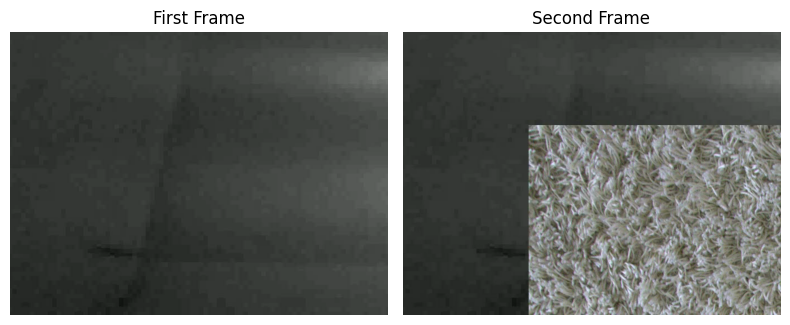

[TRUE] covered
[PREDICTED] covered
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


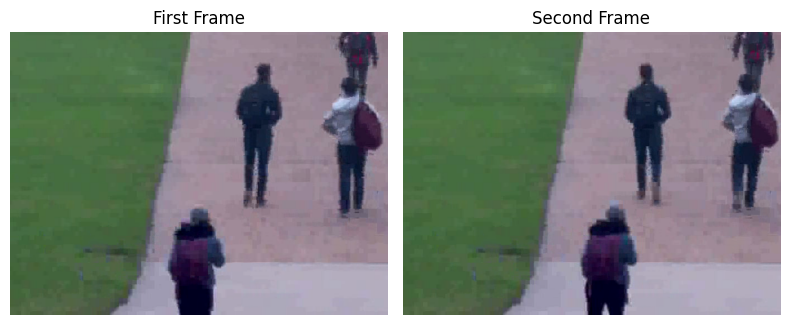

[TRUE] normal
[PREDICTED] normal
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


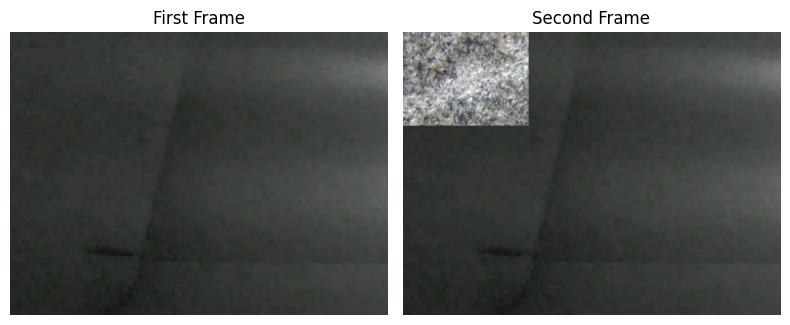

[TRUE] covered
[PREDICTED] covered
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


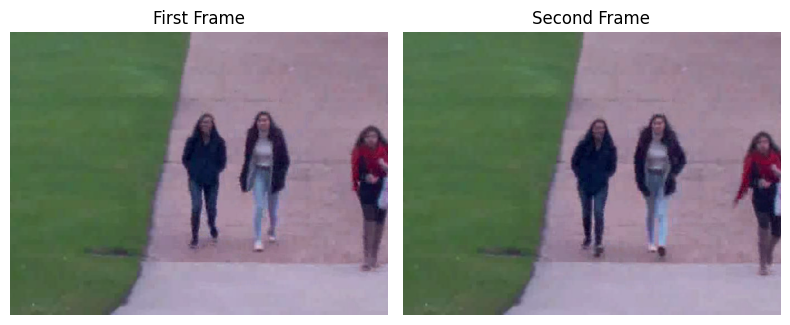

[TRUE] normal
[PREDICTED] normal
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


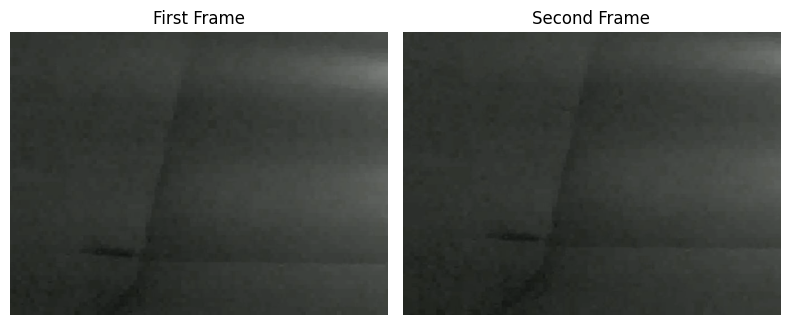

[TRUE] moved
[PREDICTED] moved
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


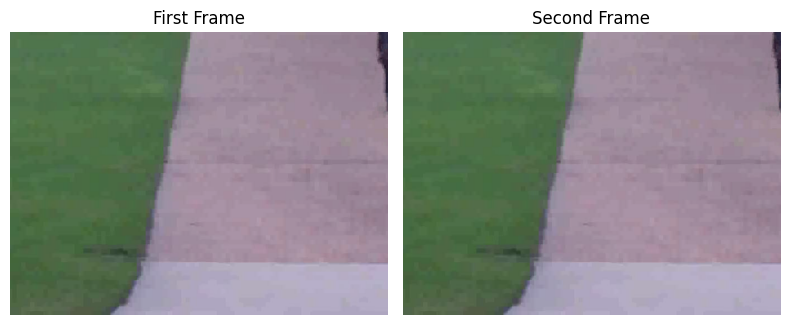

[TRUE] normal
[PREDICTED] moved
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


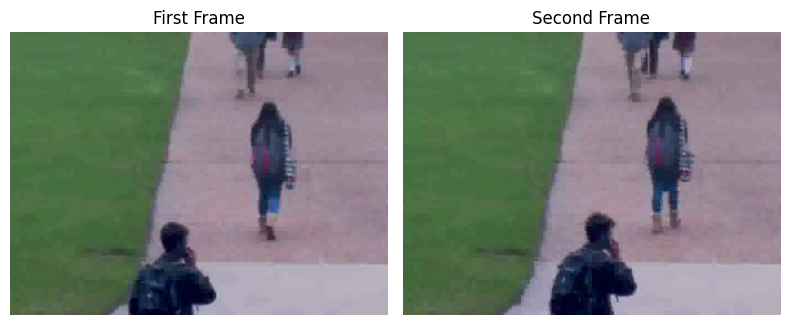

[TRUE] normal
[PREDICTED] normal
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


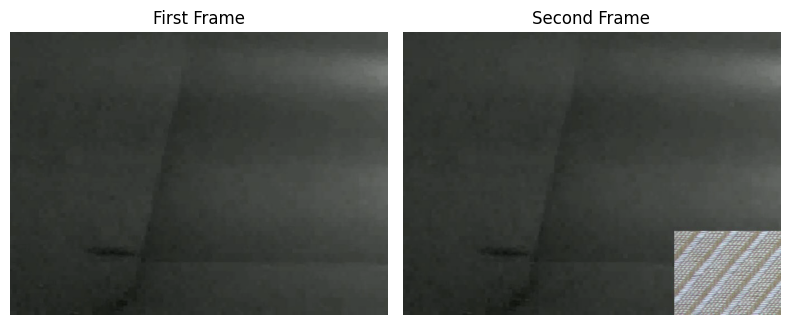

[TRUE] covered
[PREDICTED] covered
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


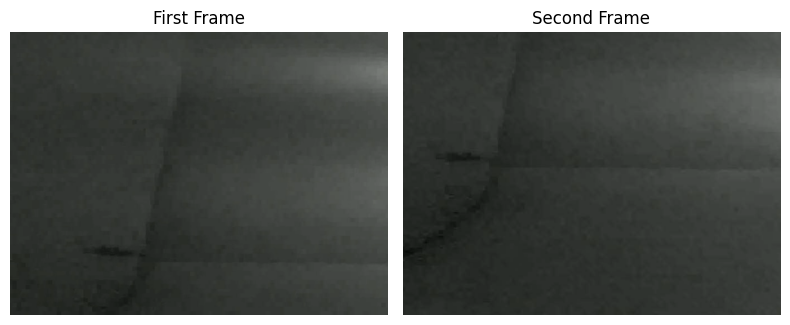

[TRUE] moved
[PREDICTED] moved
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


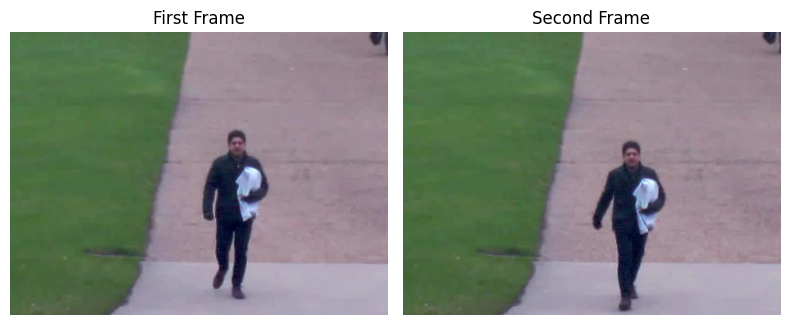

[TRUE] normal
[PREDICTED] normal
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


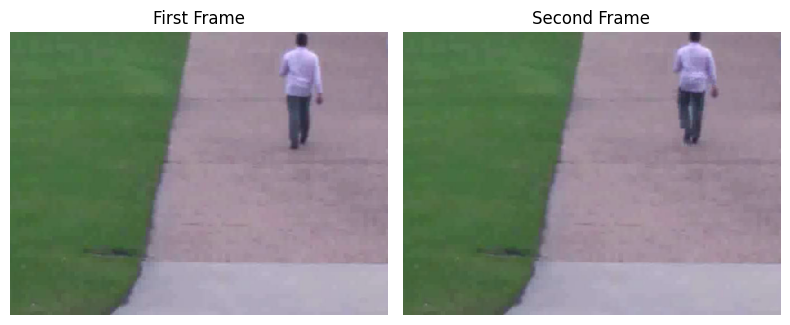

[TRUE] normal
[PREDICTED] normal
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


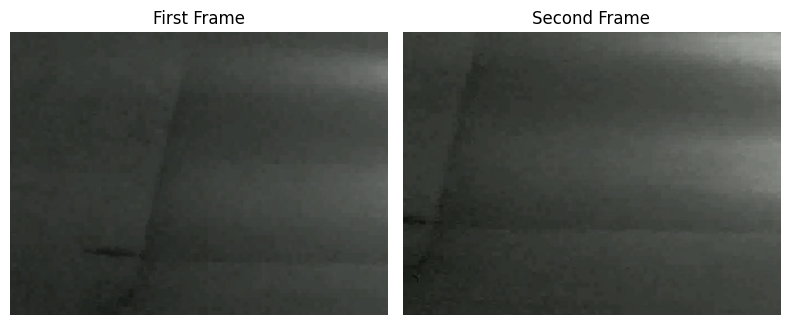

[TRUE] moved
[PREDICTED] moved
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


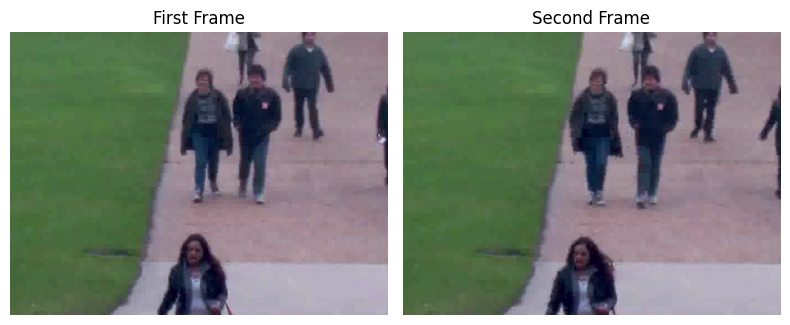

[TRUE] normal
[PREDICTED] normal
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


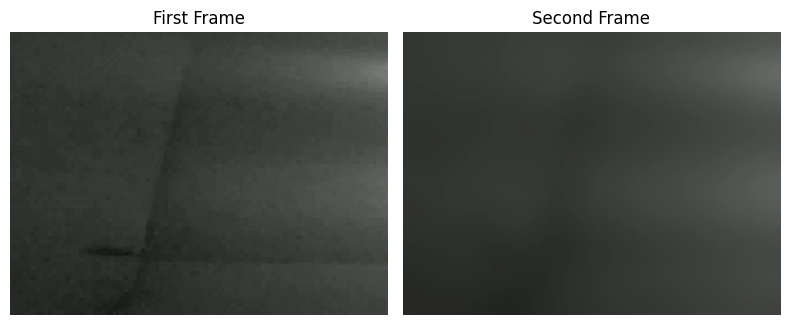

[TRUE] defocussed
[PREDICTED] defocussed
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


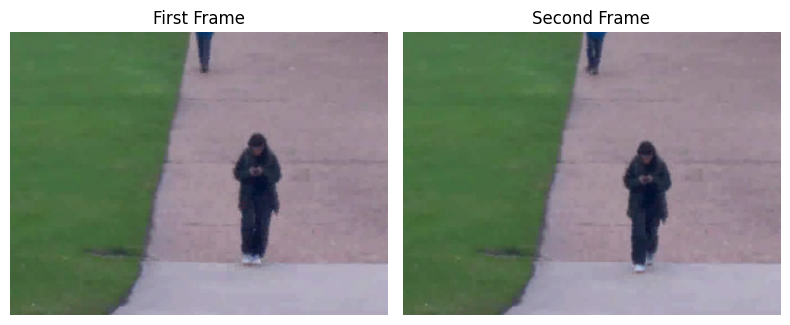

[TRUE] normal
[PREDICTED] normal
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


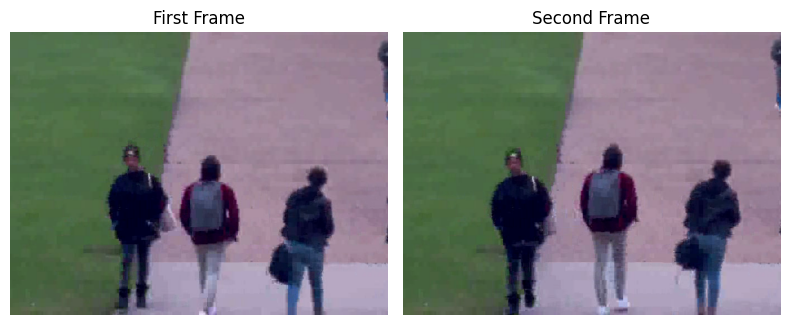

[TRUE] normal
[PREDICTED] normal
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


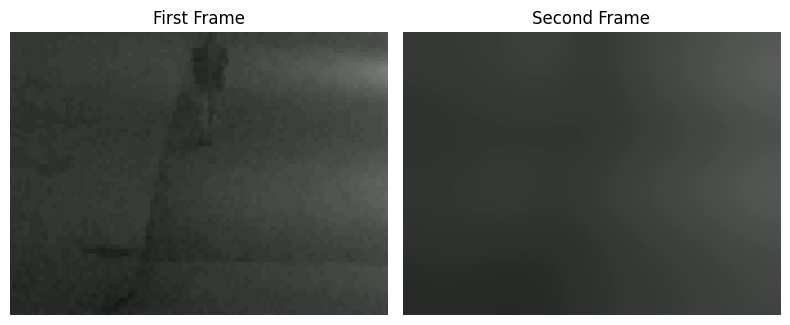

[TRUE] defocussed
[PREDICTED] defocussed
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


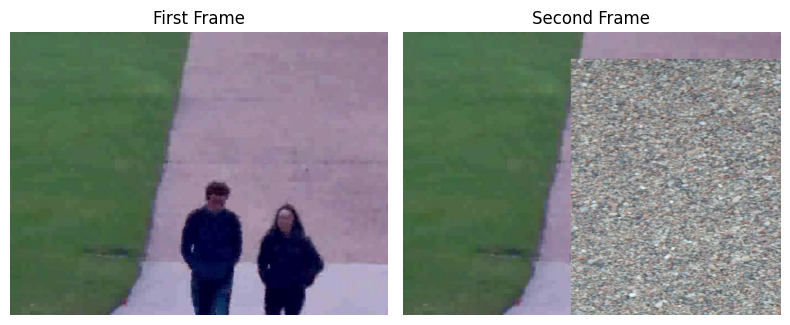

[TRUE] covered
[PREDICTED] covered
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


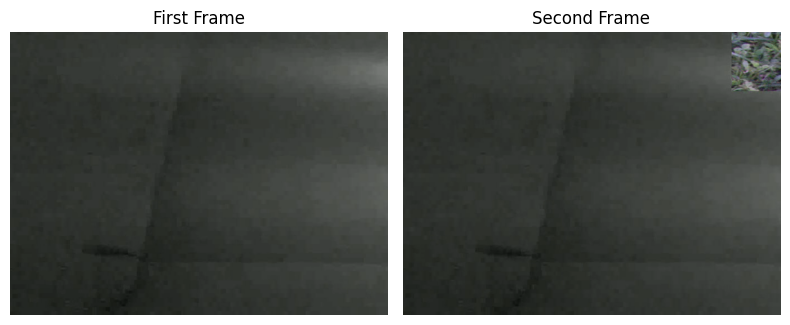

[TRUE] covered
[PREDICTED] covered
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


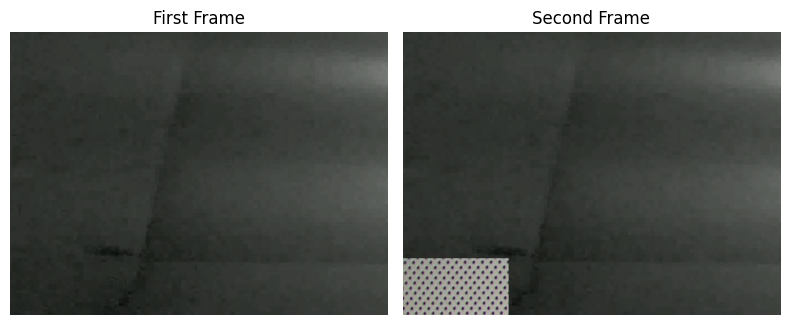

[TRUE] covered
[PREDICTED] covered
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


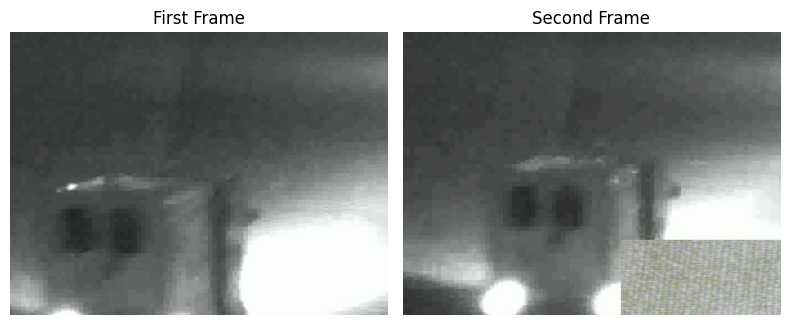

[TRUE] covered
[PREDICTED] moved
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


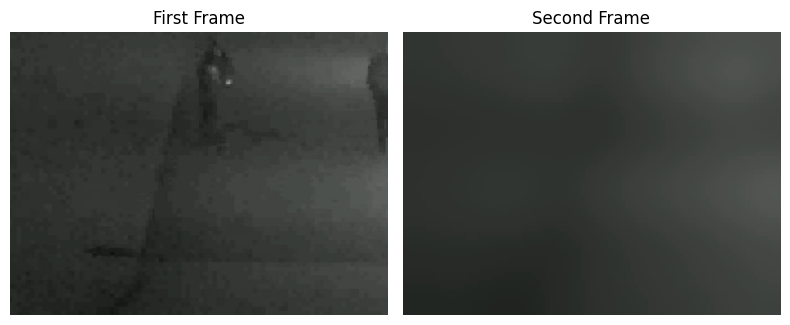

[TRUE] defocussed
[PREDICTED] defocussed
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


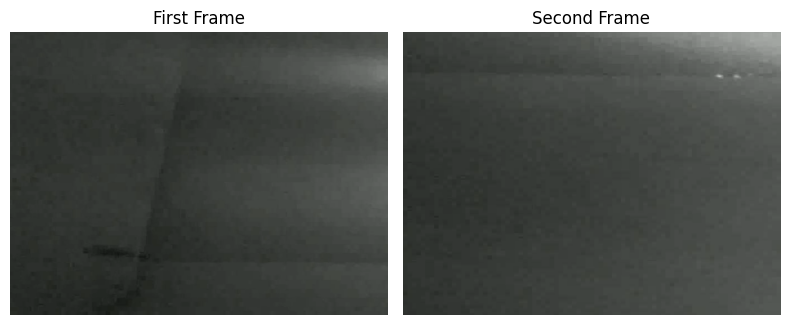

[TRUE] moved
[PREDICTED] covered
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


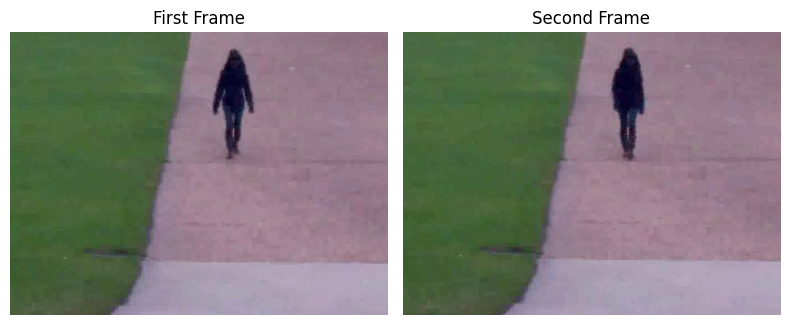

[TRUE] moved
[PREDICTED] normal
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


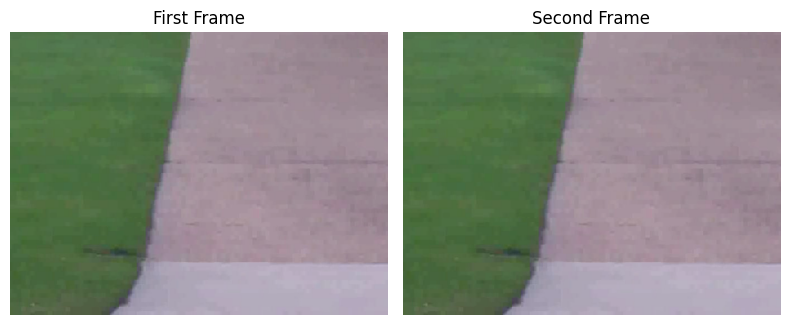

[TRUE] normal
[PREDICTED] normal
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


In [ ]:
detector = CameraSabotageDetector()

tester = SabotageTester(
    base_path="UHCTD_dataset",
    camera_name="Camera A",
    detector=detector
)

tester.run()